In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom
import cv2
from math import ceil
# import json

# from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# from imblearn.over_sampling import RandomOverSampler
import torch
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

# from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df, process_image
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, get_master_df, process_image, mask_image

In [13]:
ddsm_df = get_ddsm_table("../DDSM")
INbreast_df = get_INBreast_table("../INbreast Release 1.0")
vindr_df = get_VinDR_table("../VinDr")
master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

In [14]:
master_df.replace({'breast_density': {'DENSITY A': 1, 'DENSITY B': 2, 'DENSITY C': 3, 'DENSITY D': 4}}, inplace=True)
master_df['breast_density'] = pd.to_numeric(master_df['breast_density'], errors='coerce')
master_df.dropna(subset=['breast_density'], inplace=True)
master_df['breast_density'] = master_df['breast_density'] - 1
# master_df = master_df.groupby('breast_density').sample(n=200)

In [30]:
def load_image(row, process):
    image_size = (2600,2000)
    dicom_path = row["full_path"]
    # label = row["breast_density"]
    vendor = row["Manufacturer"]
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array
    image = mask_image(image)
    
    if process:
        image = process_image(image, vendor) # custom processing

    image = (image - np.mean(image))/np.std(image)
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)
    return image

In [5]:
def data_generator(df, batch_size, process=False):
    num_samples = len(df)
    image_size = (2600,2000)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            
            for _, row in batch_df.iterrows():
                dicom_path = row["full_path"]
                label = row["breast_density"]
                vendor = row["Manufacturer"]
                dicom_data = pydicom.dcmread(dicom_path)
                image = dicom_data.pixel_array
                image = mask_image(image)
                
                if process:
                    image = process_image(image, vendor) # custom processing

                image = (image - np.mean(image))/np.std(image)
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(label)
            
            # Convert to numpy arrays
            images = np.array(images).reshape(-1, 1, *image_size)  # Add channel dimension
            labels = np.array(labels)
            
            yield images, labels

In [6]:
batch_size = 16

train_df, temp_df = train_test_split(master_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create generators
train_gen = data_generator(train_df, batch_size, True)
val_gen = data_generator(val_df, batch_size, True)
test_gen = data_generator(test_df, batch_size, True)

# Get the number of steps per epoch
train_steps = ceil(len(train_df) // batch_size)
val_steps = ceil(len(val_df) // batch_size)
test_steps = ceil(len(test_df) // batch_size)
print(train_steps, val_steps, test_steps)


35 7 7


In [7]:
from model import BaselineBreastModel as CNNModel
model = CNNModel(device='cuda')
model = model.to('cuda')

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
best_val_loss = float('inf')
epochs_without_improvement = 0
early_stop = False
min_delta = 0.001
patience = 10

In [9]:
epochs_without_improvement = 0


In [10]:
train_losses = []
train_accuracies = []
train_f1_scores = []

val_losses = []
val_accuracies = []
val_f1_scores = []

In [11]:
for epoch in range(epochs):
    model.train()
    train_loss, train_acc, train_f1 = 0, 0, 0
    for _ in tqdm(range(train_steps), desc='Training batch'):
        images, labels = next(train_gen)
        optimizer.zero_grad()
        images = torch.tensor(images, dtype=torch.float32).to('cuda')
        labels = torch.tensor(labels, dtype=torch.long).to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        train_loss += loss.item()
        train_acc += (preds == labels).sum().item()
        train_f1 += f1_score(labels.cpu(), preds.cpu(), average='weighted')

    train_loss /= train_steps
    train_acc /= len(train_df)
    train_f1 /= train_steps
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)

    # Validation phase
    model.eval()
    val_loss, val_acc, val_f1 = 0, 0, 0
    with torch.no_grad():
        for _ in tqdm(range(val_steps), desc='Validation batch'):
            images, labels = next(val_gen)
            images = torch.tensor(images, dtype=torch.float32).to('cuda')
            labels = torch.tensor(labels, dtype=torch.long).to('cuda')            
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate metrics
            preds = torch.argmax(outputs, dim=1)
            val_loss += loss.item()
            val_acc += (preds == labels).sum().item()
            val_f1 += f1_score(labels.cpu(), preds.cpu(), average='weighted')

    val_loss /= val_steps
    val_acc /= len(val_df)
    val_f1 /= val_steps
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | Validation F1: {val_f1:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break

Validation batch: 100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch 1/20 | Train Loss: 1.3898 | Train Acc: 0.2232 | Train F1: 0.1015
Validation Loss: 1.3869 | Validation Acc: 0.2000 | Validation F1: 0.0846


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.97s/it]


Epoch 2/20 | Train Loss: 1.3865 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3867 | Validation Acc: 0.1917 | Validation F1: 0.0904


Validation batch: 100%|██████████| 7/7 [00:35<00:00,  5.03s/it]


Epoch 3/20 | Train Loss: 1.3868 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3873 | Validation Acc: 0.1750 | Validation F1: 0.0776


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.89s/it]


Epoch 4/20 | Train Loss: 1.3866 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3864 | Validation Acc: 0.2083 | Validation F1: 0.0978


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.94s/it]


Epoch 5/20 | Train Loss: 1.3864 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3871 | Validation Acc: 0.1833 | Validation F1: 0.0846


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch 6/20 | Train Loss: 1.3861 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3873 | Validation Acc: 0.1833 | Validation F1: 0.0846


Validation batch: 100%|██████████| 7/7 [00:33<00:00,  4.74s/it]


Epoch 7/20 | Train Loss: 1.3861 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3878 | Validation Acc: 0.1750 | Validation F1: 0.0776


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.91s/it]


Epoch 8/20 | Train Loss: 1.3861 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3870 | Validation Acc: 0.2000 | Validation F1: 0.0949


Validation batch: 100%|██████████| 7/7 [00:38<00:00,  5.52s/it]


Epoch 9/20 | Train Loss: 1.3860 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3878 | Validation Acc: 0.2000 | Validation F1: 0.0846


Validation batch: 100%|██████████| 7/7 [00:35<00:00,  5.03s/it]


Epoch 10/20 | Train Loss: 1.3860 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3876 | Validation Acc: 0.1917 | Validation F1: 0.0904


Validation batch: 100%|██████████| 7/7 [00:35<00:00,  5.06s/it]


Epoch 11/20 | Train Loss: 1.3860 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3886 | Validation Acc: 0.1750 | Validation F1: 0.0776


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.86s/it]


Epoch 12/20 | Train Loss: 1.3860 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3869 | Validation Acc: 0.2083 | Validation F1: 0.0978


Validation batch: 100%|██████████| 7/7 [00:34<00:00,  4.95s/it]


Epoch 13/20 | Train Loss: 1.3859 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3884 | Validation Acc: 0.1833 | Validation F1: 0.0846


Validation batch: 100%|██████████| 7/7 [00:33<00:00,  4.80s/it]

Epoch 14/20 | Train Loss: 1.3859 | Train Acc: 0.2661 | Train F1: 0.1245
Validation Loss: 1.3885 | Validation Acc: 0.1833 | Validation F1: 0.0846
Early stopping triggered!


In [17]:
torch.save(model.state_dict(), 'model.pth')
torch.save(model, 'model_full.pth')

In [5]:
import models_torch as models

In [6]:
model = models.BaselineBreastModel('cuda', nodropout_probability=1.0, gaussian_noise_std=0.0).to('cuda')
model.load_state_dict(torch.load('model.p'))

<All keys matched successfully>

In [15]:
df = master_df[master_df['Manufacturer'].isin(['SIEMENS', 'Planmed', 'IMS s.r.l.', 'IMS GIOTTO S.p.A.'])]

In [16]:
len(df)

2032

In [18]:
df.sort_values('full_path', inplace=True)

In [23]:
df.head()

,laterality,view_position,breast_density,Manufacturer,full_path
34,R,CC,1.0,SIEMENS,../VinDr\00a7a306c763ab5f0cb6a846825b7d04\2749...
35,R,MLO,1.0,SIEMENS,../VinDr\00a7a306c763ab5f0cb6a846825b7d04\2ce5...
32,L,CC,1.0,SIEMENS,../VinDr\00a7a306c763ab5f0cb6a846825b7d04\6c4c...
33,L,MLO,1.0,SIEMENS,../VinDr\00a7a306c763ab5f0cb6a846825b7d04\c7ae...
1802,R,MLO,2.0,Planmed,../VinDr\00fff3f5e68727ee9a2cceeefee31bb9\6fbd...


In [24]:
from utils import load_images

In [71]:
df['patient'] = df['full_path'].str.split('\\').str[1]

In [103]:
patients = df['patient'].unique()
goodpatients = []
for i in patients:
    rows = df[df['patient'] == i]
    views = rows['view_position'].values
    lats = rows['laterality'].values
    densities = rows['breast_density'].nunique()
    if('CC' in views and 'MLO' in views):
        if('L' in lats and 'R' in lats):
            if(len(views) == 4 and len(lats) == 4):
                if(densities == 1):
                    goodpatients.append(i)

In [104]:
df = df[df['patient'].isin(goodpatients)]

In [123]:
correct=0
device = 'cuda'

In [124]:
preds = []
labels = []

In [125]:
for i in tqdm(range(0, len(df), 4)):
    l_cc = None
    r_cc = None
    l_mlo = None
    r_mlo = None
    for j in range(4):
        row = df.iloc[i+j]
        image = load_image(row, False)
        if(row['laterality'] == 'L' and row['view_position'] == 'CC'):
            l_cc = image
        elif(row['laterality'] == 'R' and row['view_position'] == 'CC'):
            r_cc = image
        elif(row['laterality'] == 'L' and row['view_position'] == 'MLO'):
            l_mlo = image
        elif(row['laterality'] == 'R' and row['view_position'] == 'MLO'):
            r_mlo = image
    x = {
        "L-CC": torch.Tensor(l_cc).permute(0, 3, 1, 2).to(device),
        "L-MLO": torch.Tensor(l_mlo).permute(0, 3, 1, 2).to(device),
        "R-CC": torch.Tensor(r_cc).permute(0, 3, 1, 2).to(device),
        "R-MLO": torch.Tensor(r_mlo).permute(0, 3, 1, 2).to(device),
    }
    label = row['breast_density']
    with torch.no_grad():
        prediction_density = model(x).cpu()
        pred = torch.argmax(prediction_density, dim=1)
        preds.append(pred.item())
        labels.append(int(label))
        acc = (pred.item() == int(label))
        if(acc):
            correct+=1
        

100%|██████████| 479/479 [06:05<00:00,  1.31it/s]


In [126]:
df['breast_density'].value_counts()

breast_density
2.0    1468
3.0     256
1.0     184
0.0       8
Name: count, dtype: int64

In [131]:
correct/479 * 100

54.69728601252609

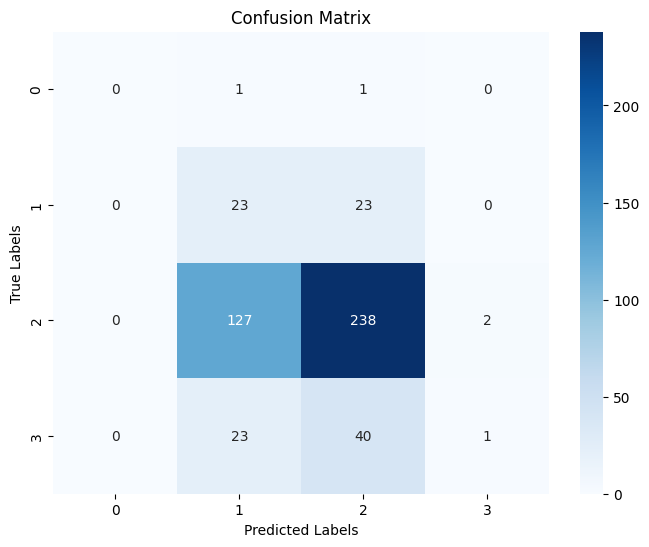

In [130]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [129]:
f1_score(labels, preds, average='weighted')

0.569212307618333

In [31]:
r_cc = load_image(df.iloc[0], False)
r_mlo = load_image(df.iloc[1], False)
l_cc = load_image(df.iloc[2], False)
l_mlo = load_image(df.iloc[3], False)


In [26]:
device = 'cuda'

In [32]:
x = {
        "L-CC": torch.Tensor(l_cc).permute(0, 3, 1, 2).to(device),
        "L-MLO": torch.Tensor(l_mlo).permute(0, 3, 1, 2).to(device),
        "R-CC": torch.Tensor(r_cc).permute(0, 3, 1, 2).to(device),
        "R-MLO": torch.Tensor(r_mlo).permute(0, 3, 1, 2).to(device),
}

In [42]:
with torch.no_grad():
        prediction_density = model(x).cpu()

In [47]:
pred = torch.argmax(prediction_density, dim=1)
pred
# pred == torch.Tensor(1)

tensor([2])

In [36]:
print('Density prediction:\n'
              '\tAlmost entirely fatty (0):\t\t\t' + str(prediction_density[0, 0]) + '\n'
              '\tScattered areas of fibroglandular density (1):\t' + str(prediction_density[0, 1]) + '\n'
              '\tHeterogeneously dense (2):\t\t\t' + str(prediction_density[0, 2]) + '\n'
              '\tExtremely dense (3):\t\t\t\t' + str(prediction_density[0, 3]) + '\n')

Density prediction:
	Almost entirely fatty (0):			0.015911328
	Scattered areas of fibroglandular density (1):	0.14773406
	Heterogeneously dense (2):			0.61962146
	Extremely dense (3):				0.21673316



In [16]:
master_df['Manufacturer'].value_counts()

Manufacturer
SIEMENS              290
Siemens_INBreast     221
DDSM                 185
Planmed               83
IMS s.r.l.            15
IMS GIOTTO S.p.A.      6
Name: count, dtype: int64

In [16]:
images, labels = next(test_gen)
images = torch.tensor(images, dtype=torch.float32).to('cuda')
labels = torch.tensor(labels, dtype=torch.long).to('cuda') 
model(images)

tensor([[0.2365, 0.2367, 0.2908, 0.2360],
        [0.2368, 0.2367, 0.2916, 0.2349],
        [0.2354, 0.2380, 0.2908, 0.2358],
        [0.2395, 0.2379, 0.2879, 0.2348],
        [0.2347, 0.2351, 0.2964, 0.2338],
        [0.2354, 0.2363, 0.2938, 0.2345],
        [0.2348, 0.2378, 0.2921, 0.2353],
        [0.2383, 0.2372, 0.2909, 0.2336],
        [0.2357, 0.2365, 0.2923, 0.2356],
        [0.2350, 0.2358, 0.2938, 0.2353],
        [0.2378, 0.2371, 0.2901, 0.2349],
        [0.2367, 0.2359, 0.2921, 0.2353],
        [0.2400, 0.2393, 0.2861, 0.2346],
        [0.2379, 0.2374, 0.2901, 0.2346],
        [0.2370, 0.2376, 0.2894, 0.2360],
        [0.2355, 0.2370, 0.2922, 0.2353]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)